In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from tqdm import tqdm
# import acd
from random import randint
from copy import deepcopy
import pickle as pkl
import argparse

sys.path.append('../../src')
sys.path.append('../../src/vae')
sys.path.append('../../src/vae/models')
sys.path.append('../../src/dsets/images')
from dset import get_dataloaders
from model import init_specific_model
from losses import get_loss_f
from training import Trainer
from viz import viz_im_r

sys.path.append('../../lib/trim')
# trim modules
from trim import DecoderEncoder

sys.path.append('../../lib/disentangling-vae')
import main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Train model

In [2]:
class p:
    '''Parameters for Gaussian mixture simulation
    '''
    # parameters for generating data
    seed = 13
    dataset = "dsprites"
    
    # parameters for model architecture
    model_type = "Burgess"
    latent_dim = 10 
    img_size = (1, 64, 64)
    
    # parameters for training
    train_batch_size = 64
    test_batch_size = 100
    lr = 1e-4
    rec_dist = "bernoulli"
    reg_anneal = 0
    num_epochs = 100
    
    # hyperparameters for loss
    beta = 0.01
    lamPT = 0.0
    lamNN = 0.0
    lamH = 0.0
    lamSP = 0.0
    
    # parameters for exp
    warm_start = None # which parameter to warm start with respect to
    seq_init = 1      # value of warm_start parameter to start with respect to
    
    # SAVE MODEL
    out_dir = "/home/ubuntu/local-vae/notebooks/ex_dsprites/results" # wooseok's setup
#     out_dir = '/scratch/users/vision/chandan/local-vae' # chandan's setup
    dirname = "vary"
    pid = ''.join(["%s" % randint(0, 9) for num in range(0, 10)])

    def _str(self):
        vals = vars(p)
        return 'beta=' + str(vals['beta']) + '_lamPT=' + str(vals['lamPT']) + '_lamNN=' + str(vals['lamNN']) + '_lamSP=' + str(vals['lamSP']) \
                + '_seed=' + str(vals['seed']) + '_pid=' + vals['pid']
    
    def _dict(self):
        return {attr: val for (attr, val) in vars(self).items()
                 if not attr.startswith('_')}

In [3]:
# create dir
out_dir = opj(p.out_dir, p.dirname)
os.makedirs(out_dir, exist_ok=True)  

# seed
random.seed(p.seed)
np.random.seed(p.seed)
torch.manual_seed(p.seed)

# get dataloaders
train_loader = get_dataloaders(p.dataset,
                               batch_size=p.train_batch_size,
                               logger=None)

# prepare model
model = init_specific_model(model_type=p.model_type, 
                            img_size=p.img_size,
                            latent_dim=p.latent_dim,
                            hidden_dim=None).to(device)
# model.load_state_dict(torch.load('results/dsprites.pth'))

# train
optimizer = torch.optim.Adam(model.parameters(), lr=p.lr)
loss_f = get_loss_f(decoder=model.decoder, **vars(p))
trainer = Trainer(model, optimizer, loss_f, device=device)

In [13]:
trainer(train_loader, epochs=p.num_epochs)

====> Epoch: 0 Average train loss: 454.2503
====> Epoch: 1 Average train loss: 117.2295
====> Epoch: 2 Average train loss: 100.6720
====> Epoch: 3 Average train loss: 89.8721
====> Epoch: 4 Average train loss: 85.2039
====> Epoch: 5 Average train loss: 71.9245
====> Epoch: 6 Average train loss: 67.5513
====> Epoch: 7 Average train loss: 64.9348
====> Epoch: 8 Average train loss: 62.6947
====> Epoch: 9 Average train loss: 60.4549
====> Epoch: 10 Average train loss: 58.0562
====> Epoch: 11 Average train loss: 55.2545
====> Epoch: 12 Average train loss: 52.0855
====> Epoch: 13 Average train loss: 48.7365
====> Epoch: 14 Average train loss: 45.9909
====> Epoch: 15 Average train loss: 44.0056
====> Epoch: 16 Average train loss: 42.1119
====> Epoch: 17 Average train loss: 40.4537
====> Epoch: 18 Average train loss: 38.6026
====> Epoch: 19 Average train loss: 37.2833
====> Epoch: 20 Average train loss: 35.7892
====> Epoch: 21 Average train loss: 34.6436
====> Epoch: 22 Average train loss: 33.

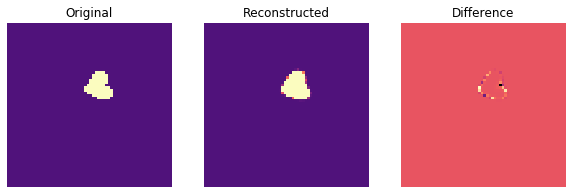

In [23]:
im = iter(train_loader).next()[0].to(device)
recon_data, latent_dist, latent_sample = model(im)
viz_im_r(im[10,0], recon_data[10,0])
torch.save(model.state_dict(), 'results/dsprites.pth')

In [34]:
from scipy import stats
from visualize import Visualizer
import torch.nn.functional as F
from visualize import make_grid_img, get_samples
from torchvision.utils import make_grid

In [47]:
model_dir = opj('results/cosmo')
model.eval()  # don't sample from latent: use mean
viz = Visualizer(model=model,
                 model_dir=model_dir,
                 save_images=False)
n_rows = 10
n_cols = 10
size = (n_rows, n_cols)
num_samples = n_rows * n_cols
samples = get_samples(train_loader.dataset, num_samples)

In [48]:
a = viz.traversals(data=samples[0:1, ...],
               n_per_latent=n_cols,
               n_latents=n_rows,
               is_force_return=True)

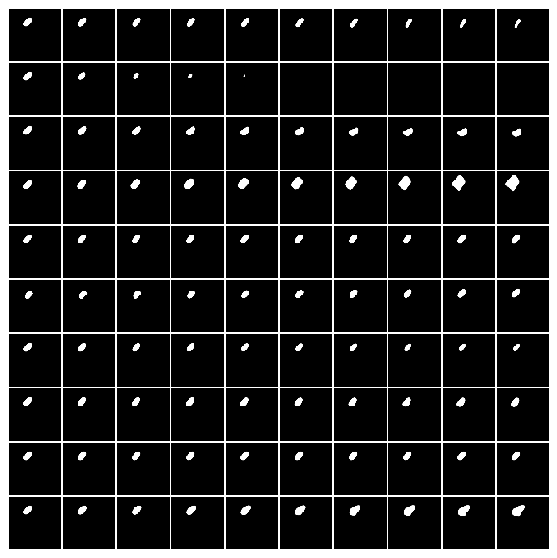

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(a, cmap='magma')
plt.axis('off')
plt.show()